# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Data Preprocessing](#Data-Preprocessing)
  - [Target Mean Encoding](#Target-Mean-Encoding)
  - [Categorical EDA](#Categorical-EDA)
  - [Manual Imputing Categories](#Manual-Imputing-Categories)
  - [Numerical EDA](#Numerical-EDA)
- [Pipeline Building](#Pipeline-Building)
- [Raw Modeling](#Raw-Modeling)
- [Results](#Results)
- [Conclusion](#Conclusion)

#  Introduction

### Regression Analysis with Linear Models

In this analysis, we focus on regression analysis, particularly preprocessing, exploratory data analysis (EDA), and a raw estimate of the model for linear regression.

#### Day 1: Preprocessing and EDA


## Importing Libraries

In [194]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [195]:
data=pl.read_csv("CarPrice_Assignment.csv")
data.head()

car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,i64,str,str,str,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64
1,3,"""alfa-romero giulia""","""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,"""alfa-romero stelvio""","""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,"""alfa-romero Quadrifoglio""","""gas""","""std""","""two""","""hatchback""","""rwd""","""front""",94.5,171.2,65.5,52.4,2823,"""ohcv""","""six""",152,"""mpfi""",2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,"""audi 100 ls""","""gas""","""std""","""four""","""sedan""","""fwd""","""front""",99.8,176.6,66.2,54.3,2337,"""ohc""","""four""",109,"""mpfi""",3.19,3.4,10.0,102,5500,24,30,13950.0
5,2,"""audi 100ls""","""gas""","""std""","""four""","""sedan""","""4wd""","""front""",99.4,176.6,66.4,54.3,2824,"""ohc""","""five""",136,"""mpfi""",3.19,3.4,8.0,115,5500,18,22,17450.0


Check for Linearity between independent variables and dependent variable

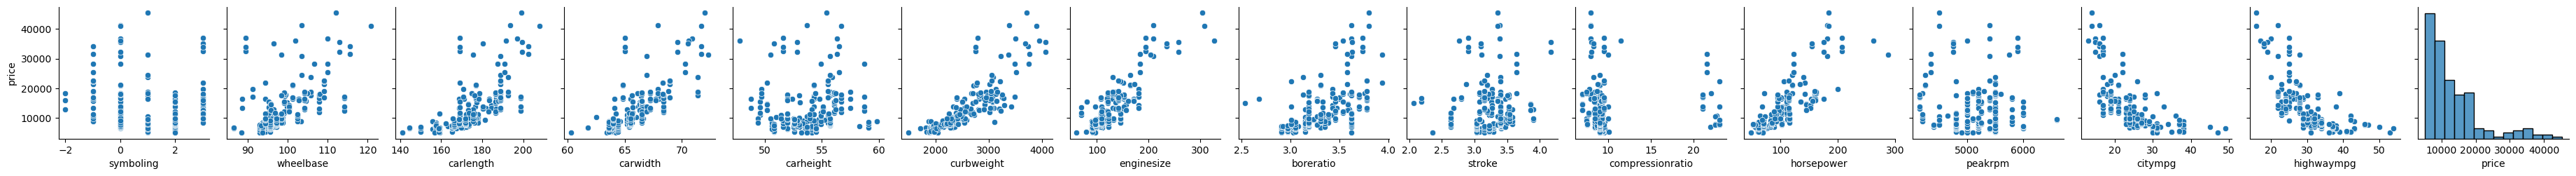

In [196]:
sns.pairplot(data.drop("car_ID").to_pandas(),y_vars=["price"])
plt.show()

Dependent variable is much skewed and many linear regression assumption are violating

Missing Values

In [197]:
data.null_count()

car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No missing

In [198]:
data.shape,data.unique(subset=data.drop("car_ID").columns,maintain_order=True).shape

((205, 26), (205, 26))

In [199]:
cat_cols=[col for col in data.columns if data[col].dtype== pl.String]
num_cols=[col for col in data.drop("car_ID","price").columns if data[col].dtype!= pl.String]

### Splitting data to avoiding data leakages [Learn more](https://en.wikipedia.org/wiki/Leakage_(machine_learning))

In [200]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data[["car_ID","price"]],test_size=0.3,random_state=42,shuffle=True,stratify=data[['symboling']])
train_data=X_train.join(y_train,on="car_ID")
test_data=X_test.join(y_test,on="car_ID")
train_data.shape,test_data.shape

((143, 26), (62, 26))

random state 42 for every process for consistency

# Data-Preprocessing

### Target Mean Encoding ##

extracting brand names

In [201]:
l=data["CarName"].str.split(" ")
brands=[]
for i in l:
    brands.append(i[0])
data=data.with_columns(pl.Series(brands).alias("CarName"))
data=data.with_columns(data["CarName"].str.replace("porsche","porcshce"))

In [202]:
train_data=train_data.drop("CarName").join(data[["car_ID","CarName"]],on="car_ID")
test_data=test_data.drop("CarName").join(data[["car_ID","CarName"]],on="car_ID")

In [203]:
encoder_list=train_data[['CarName','price']].group_by(["CarName"]).agg(pl.median("price")).sort(by="price")
encoder_list

CarName,price
str,f64
"""Nissan""",5499.0
"""maxda""",5645.0
"""chevrolet""",6435.0
"""plymouth""",6919.0
"""honda""",7295.0
…,…
"""volvo""",18420.0
"""bmw""",27662.5
"""porcshce""",31964.25


In [204]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=4,encode='ordinal',strategy='quantile') # from power bi report 4 bins looks good

discretizer.fit(encoder_list[['price']])
bins = discretizer.transform(encoder_list[['price']])

# Print bin labels (array format)
encoder_list=encoder_list.hstack(pl.DataFrame(bins,schema=["carclass"]))
encoder_list

CarName,price,carclass
str,f64,f64
"""Nissan""",5499.0,0.0
"""maxda""",5645.0,0.0
"""chevrolet""",6435.0,0.0
"""plymouth""",6919.0,0.0
"""honda""",7295.0,0.0
…,…,…
"""volvo""",18420.0,3.0
"""bmw""",27662.5,3.0
"""porcshce""",31964.25,3.0


Checking for new brands in test

In [205]:
for i in set(test_data["CarName"]):
    if i not in set(train_data["CarName"]):
        print(i)

No new brands in test set,otherwise some replacing techniques should be adadpted like knnclassifer to guess closer brand

In [206]:
def mean_encoder(x):
    if encoder_list.filter(encoder_list['CarName']==x).is_empty(): # For new brands imputing with mean prices
        return encoder_list['price'].median()
    return encoder_list.filter(encoder_list['CarName']==x)['price'][0]
def car_class(x):
    if encoder_list.filter(encoder_list['CarName']==x).is_empty(): # For new brands imputing with mean prices
        return encoder_list['carclass'].median()                     
    return encoder_list.filter(encoder_list['CarName']==x)["carclass"][0]
    
train_data=train_data.with_columns(train_data['CarName'].map_elements(lambda x:car_class(x),return_dtype=pl.Float64).alias("carclass"))
test_data=test_data.with_columns(test_data['CarName'].map_elements(lambda x:car_class(x),return_dtype=pl.Float64).alias("carclass"))
train_data=train_data.with_columns(train_data['CarName'].map_elements(lambda x:mean_encoder(x),return_dtype=pl.Float64).alias("brandavg")).drop("CarName")
test_data=test_data.with_columns(test_data['CarName'].map_elements(lambda x:mean_encoder(x),return_dtype=pl.Float64).alias("brandavg")).drop("CarName")

In [207]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Categorical EDA

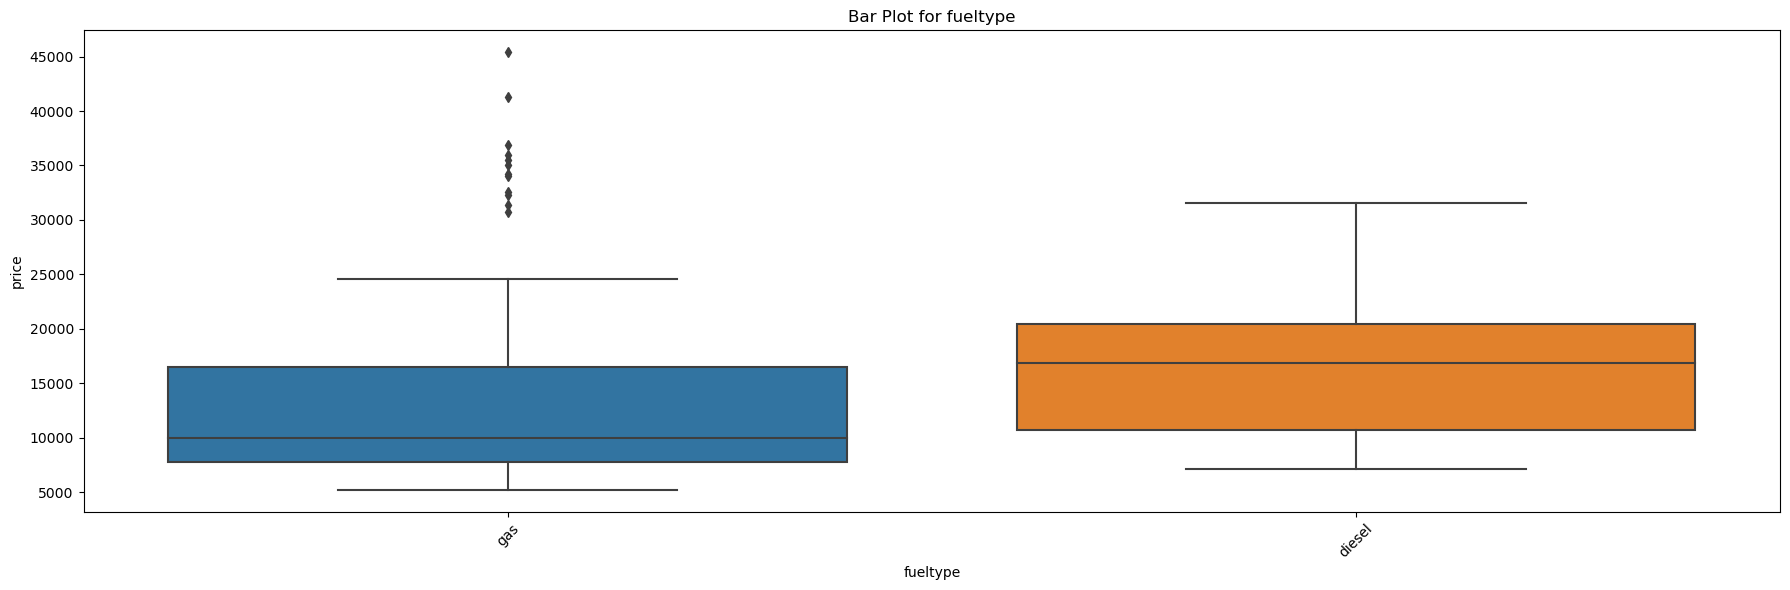

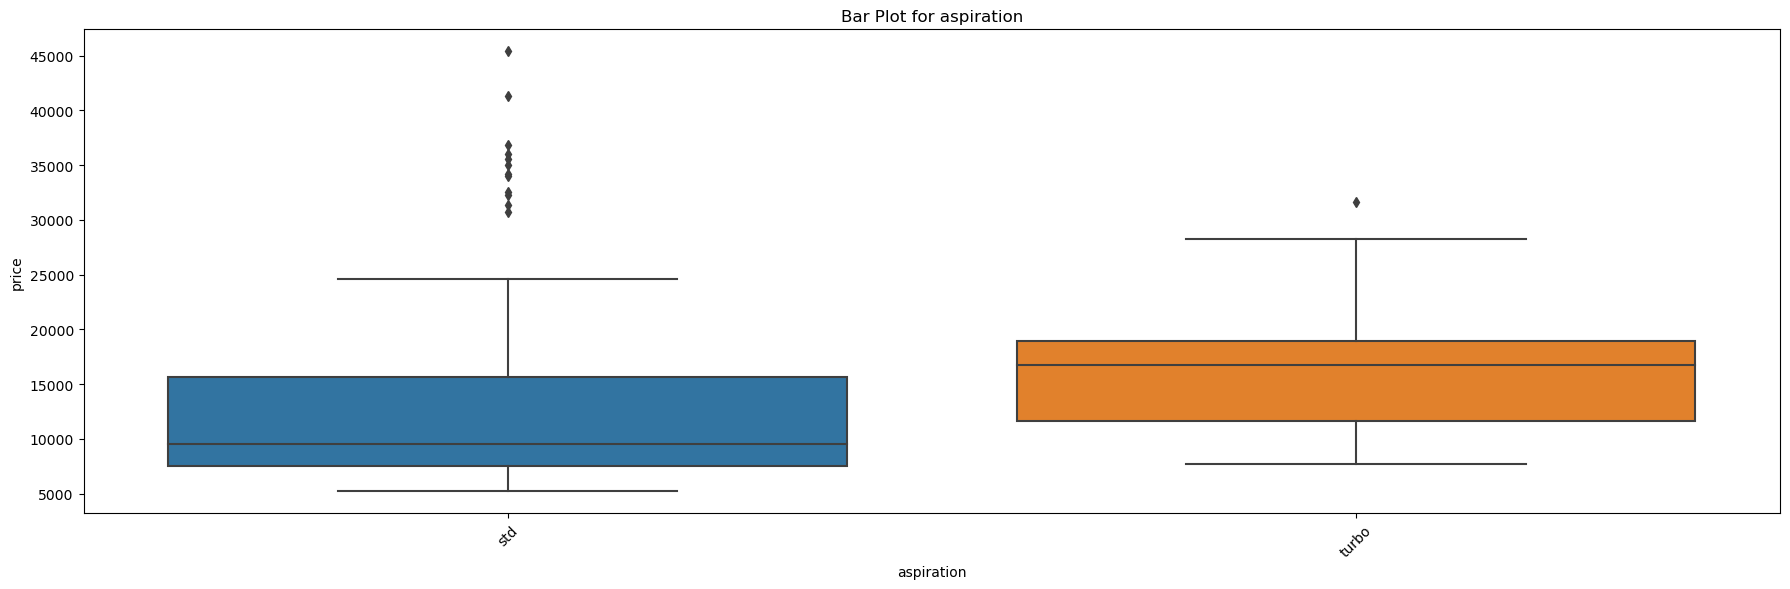

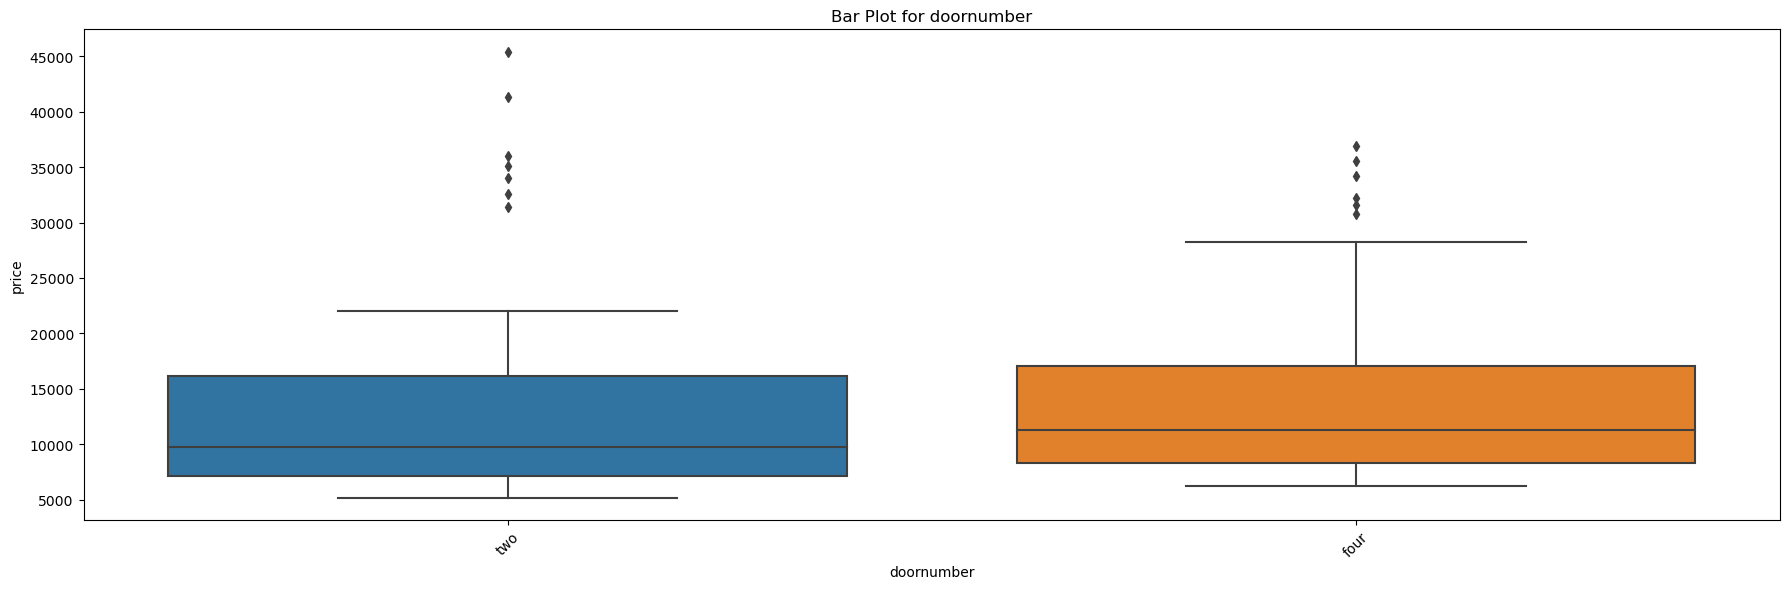

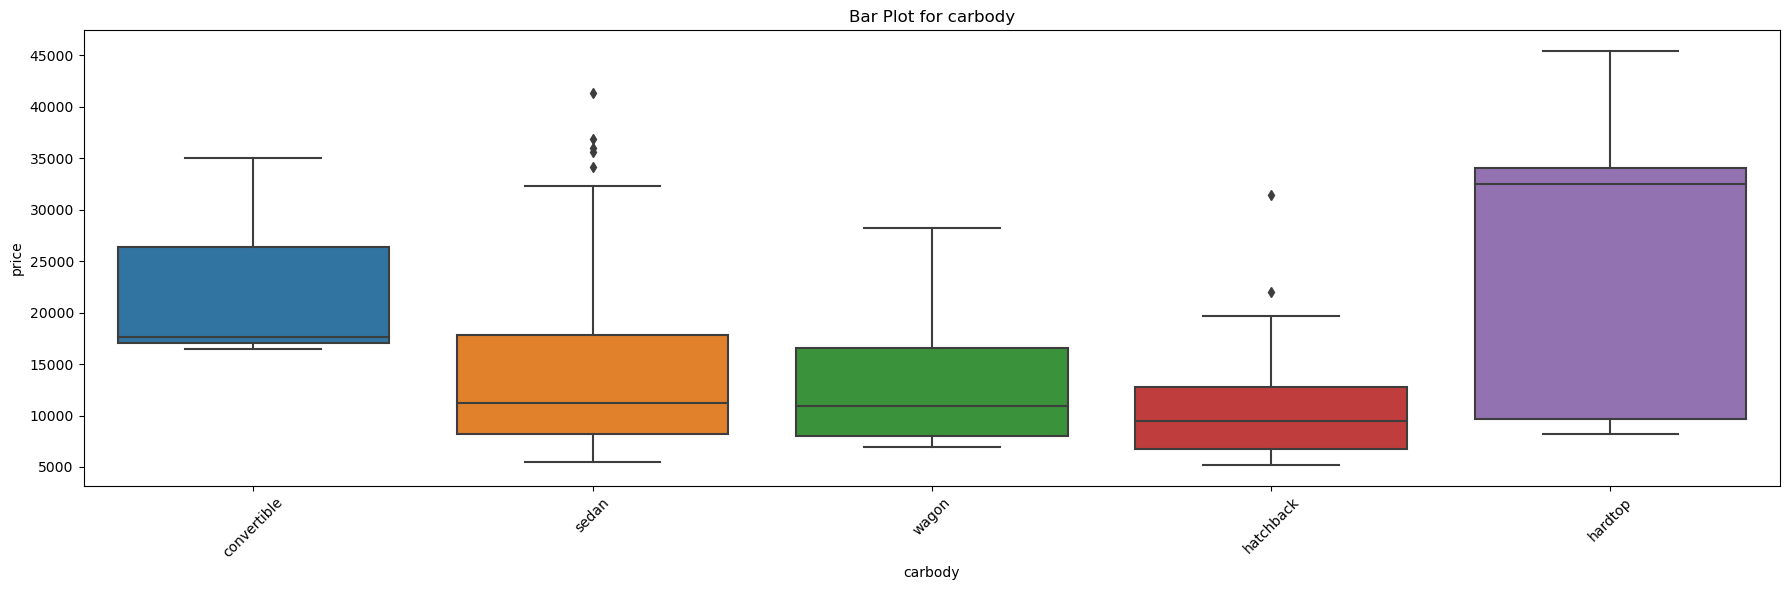

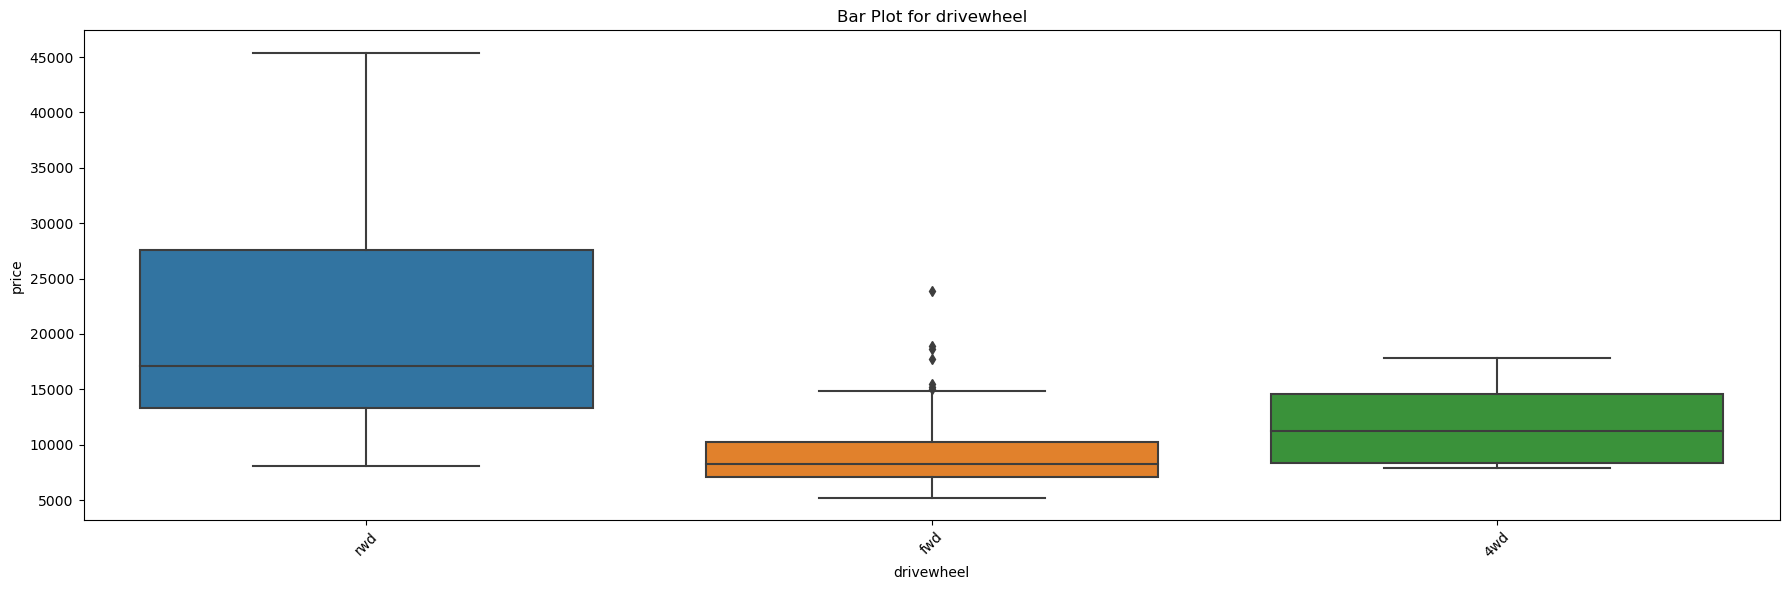

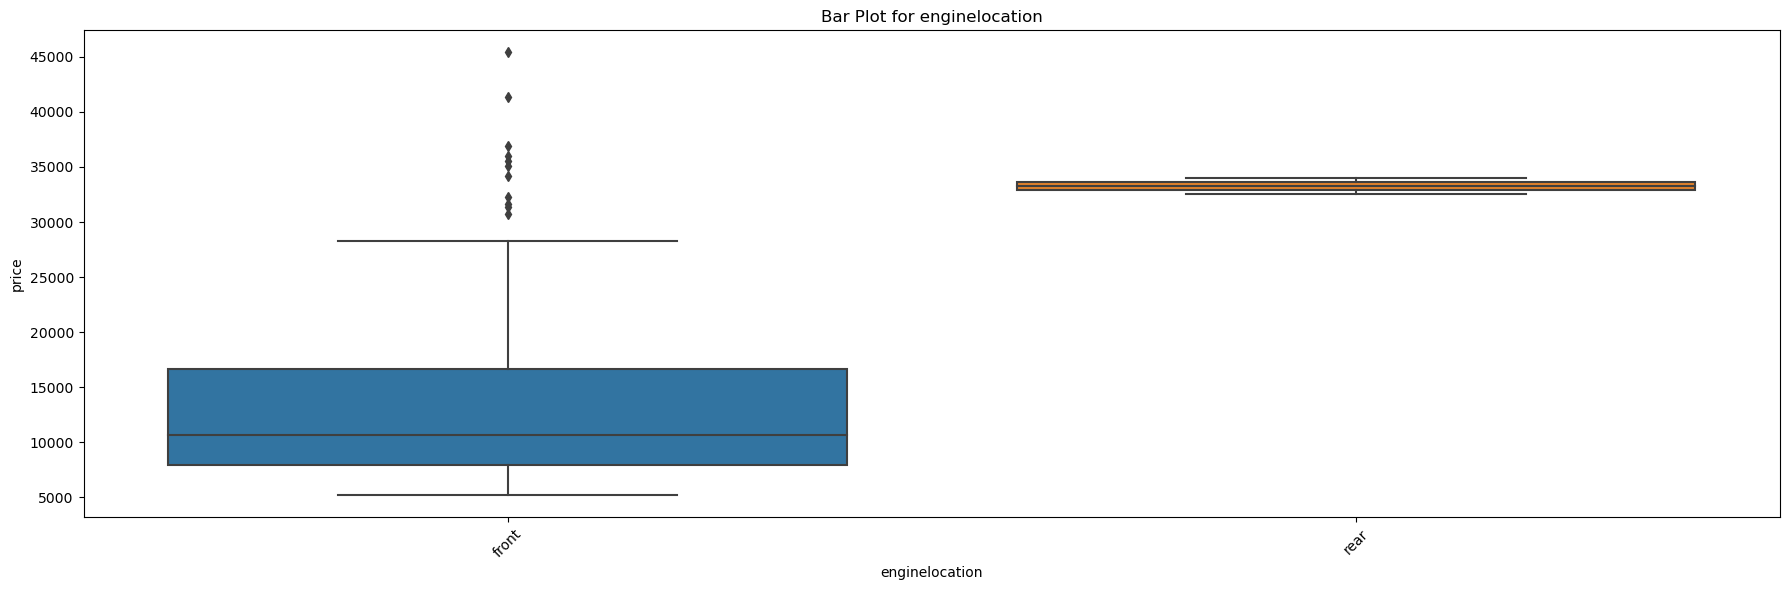

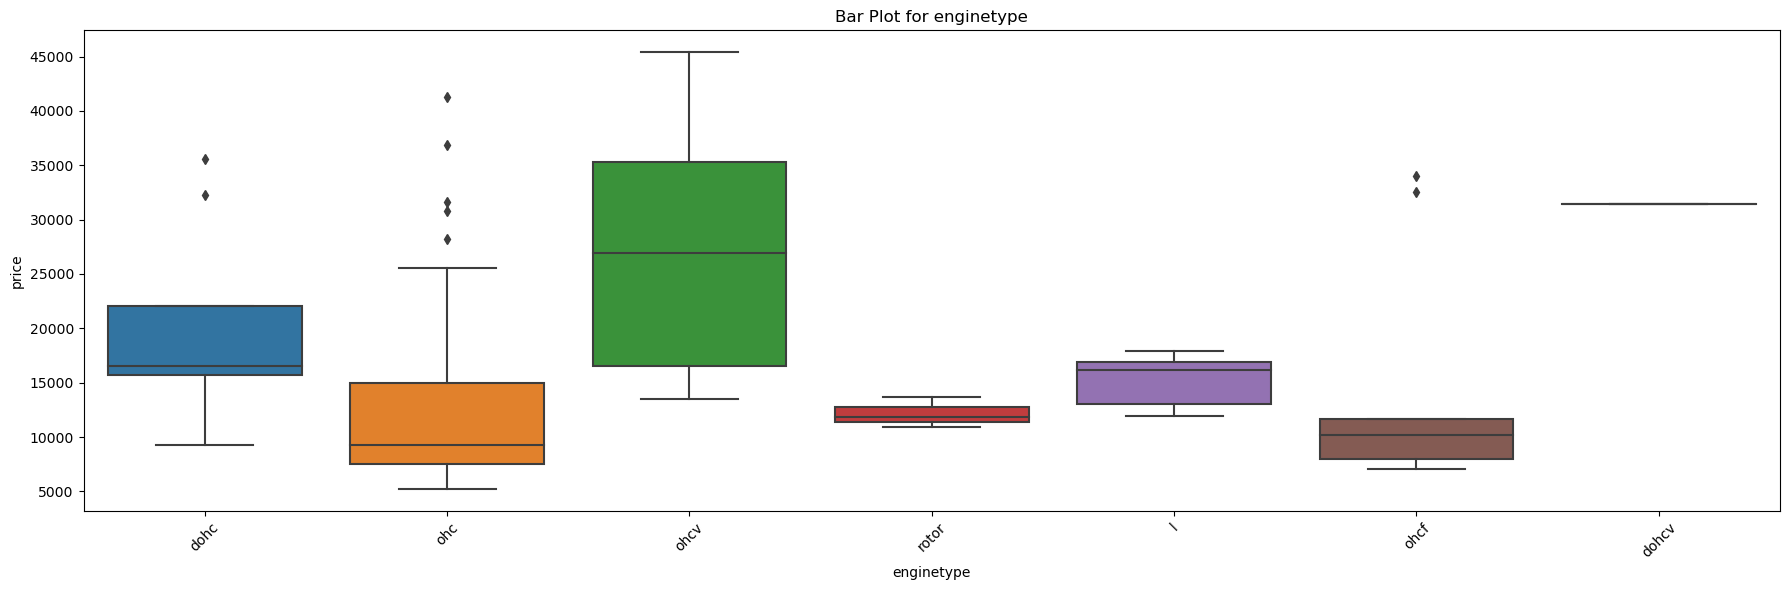

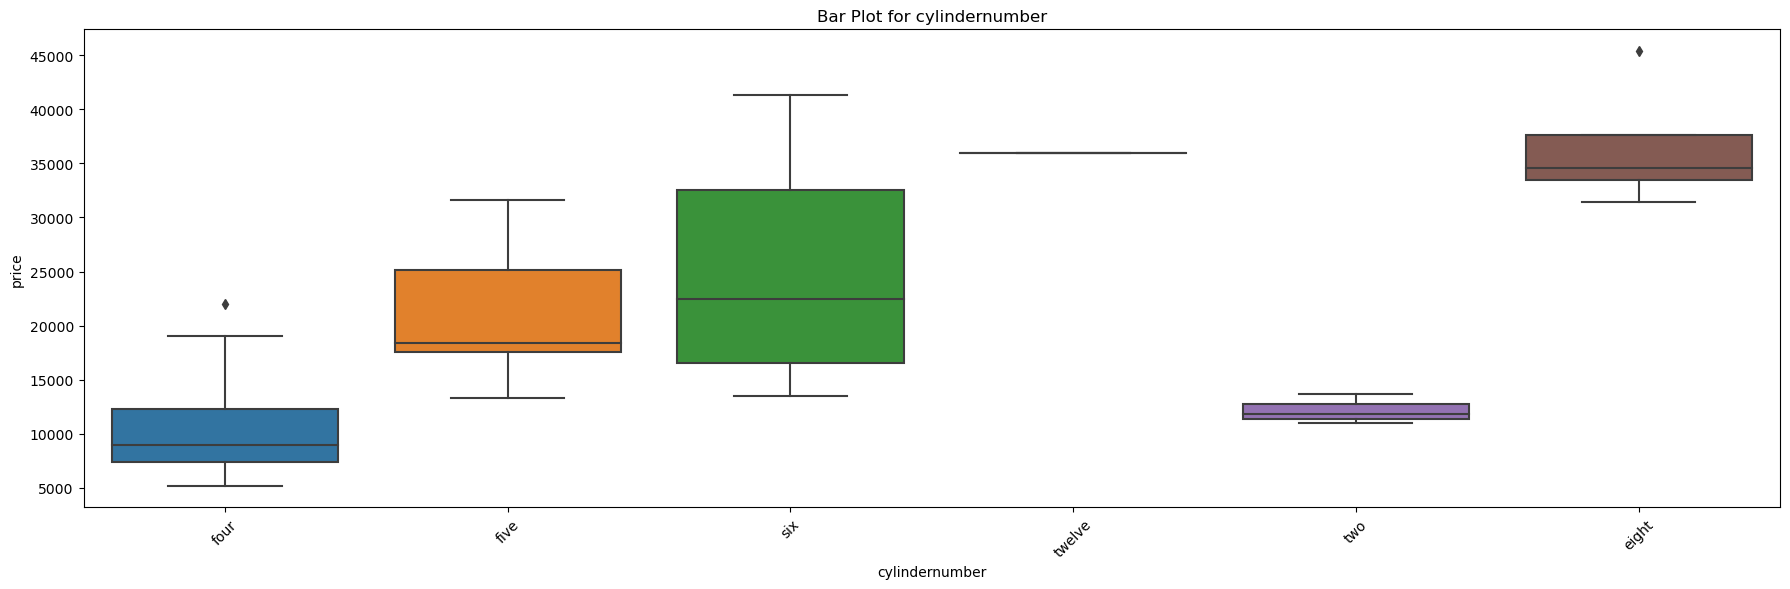

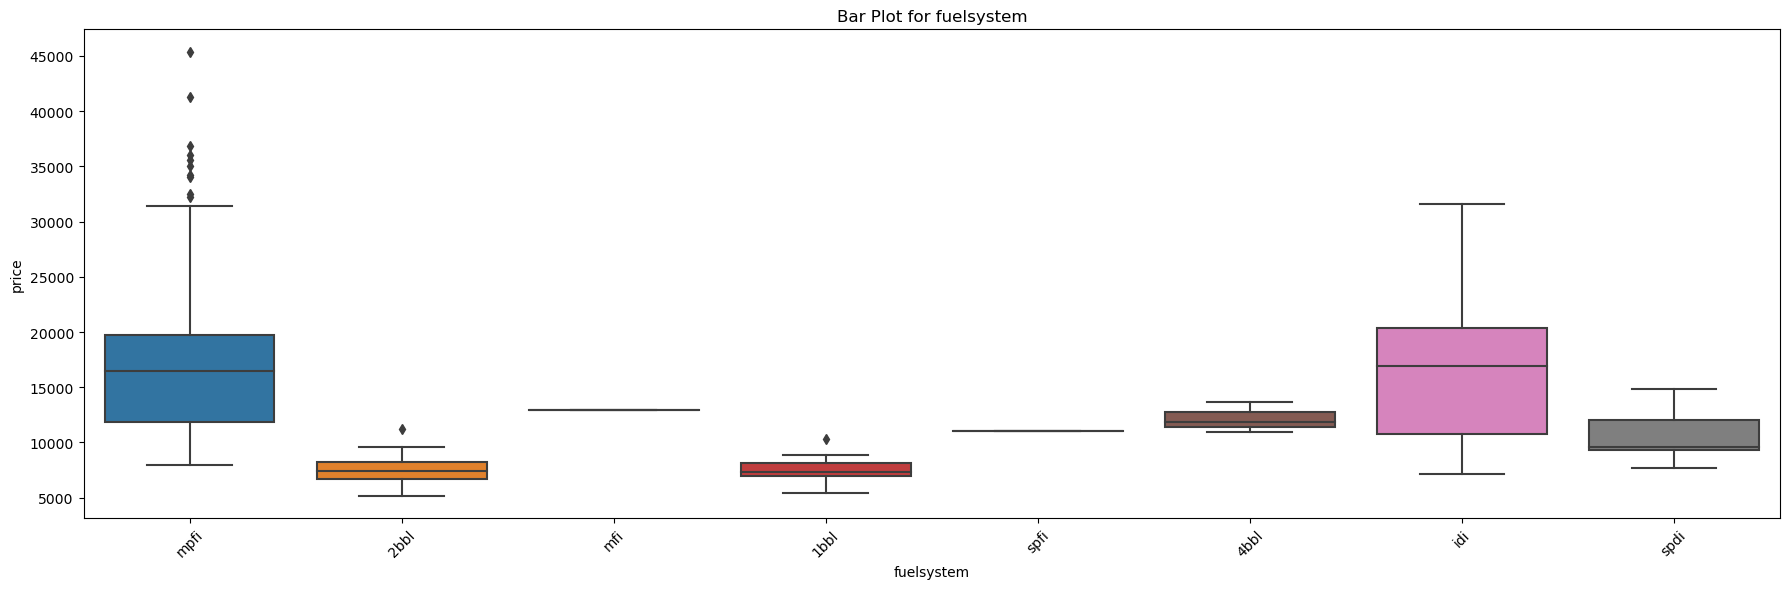

In [208]:
categorical_box_plot(train_data.to_pandas(),cat_cols,"price")

Some outliers present feature wise, they can be dropped or investigated in error analysis

**Performing Kruskal-Walli test (rank based) instead of ANOVA as data not following normal distribution**

In [209]:
perform_non_normal_kruskal_hypothesis(train_data,cat_cols,"price",alpha=0.05)

Kruskal-Wallis H-statistic: 4.641063240885674 P-value: 0.031215657007225634
There is a significant difference in price between different fueltype categories.

Kruskal-Wallis H-statistic: 13.472246140368902 P-value: 0.0002421182897620171
There is a significant difference in price between different aspiration categories.

Kruskal-Wallis H-statistic: 3.0173779823897773 P-value: 0.0823765534301663
There is no significant difference in price between different doornumber categories.

Kruskal-Wallis H-statistic: 14.741270074151037 P-value: 0.00526904954422455
There is a significant difference in price between different carbody categories.

Kruskal-Wallis H-statistic: 67.94961257484405 P-value: 1.757636673410337e-15
There is a significant difference in price between different drivewheel categories.

Kruskal-Wallis H-statistic: 4.766301855878229 P-value: 0.02902210276438481
There is a significant difference in price between different enginelocation categories.

Kruskal-Wallis H-statistic: 28.51

Dropping dorrnumber,fueltype

In [210]:
train_data=train_data.drop("doornumber")
test_data=test_data.drop("doornumber")
cat_cols.remove("doornumber")

train_data=train_data.drop("fueltype")  # near to 0.05
test_data=test_data.drop("fueltype")
cat_cols.remove("fueltype")

In [211]:
for i in cat_cols:
    print(train_data[i].value_counts())

shape: (2, 2)
┌────────────┬───────┐
│ aspiration ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ std        ┆ 115   │
│ turbo      ┆ 28    │
└────────────┴───────┘
shape: (5, 2)
┌─────────────┬───────┐
│ carbody     ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ wagon       ┆ 20    │
│ hardtop     ┆ 5     │
│ sedan       ┆ 71    │
│ convertible ┆ 3     │
│ hatchback   ┆ 44    │
└─────────────┴───────┘
shape: (3, 2)
┌────────────┬───────┐
│ drivewheel ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ 4wd        ┆ 7     │
│ rwd        ┆ 54    │
│ fwd        ┆ 82    │
└────────────┴───────┘
shape: (2, 2)
┌────────────────┬───────┐
│ enginelocation ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ rear           ┆ 2     │
│ front          ┆ 141   │
└────────────────┴───────┘
shape: (7, 2)
┌────────────┬───────┐
│ enginetype ┆ count │
│ ---        

Many columns with less value counts

In [212]:
train_data.filter((train_data['enginelocation']=="rear"))

car_ID,symboling,aspiration,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,carclass,brandavg
i64,i64,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64
127,3,"""std""","""hardtop""","""rwd""","""rear""",89.5,168.9,65.0,51.6,2756,"""ohcf""","""six""",194,"""mpfi""",3.74,2.9,9.5,207,5900,17,25,32528.0,3.0,31964.25
128,3,"""std""","""hardtop""","""rwd""","""rear""",89.5,168.9,65.0,51.6,2756,"""ohcf""","""six""",194,"""mpfi""",3.74,2.9,9.5,207,5900,17,25,34028.0,3.0,31964.25


Enginelocation has only 2 entries with different categories can cause problems in cross validation results as in some cases the entire feature will be constant.dropping it can increase performance. And they they are probably sports cars

In [213]:
train_data=train_data.filter(~(train_data['enginelocation']=="rear"))
test_data=test_data.filter(~(test_data['enginelocation']=="rear"))
train_data=train_data.drop("enginelocation")
test_data=test_data.drop("enginelocation")

cat_cols.remove("enginelocation")

# Manual Imputing Categories

some insights are from powerbi reports

In [214]:
train_data= train_data.filter(~(train_data['enginetype']=='dohcv')) # only one observation
train_data=train_data.with_columns(train_data["drivewheel"].str.replace_many(["4wd"],["fwd"]))
train_data=train_data.with_columns(train_data["drivewheel"].is_in(["rwd"]).cast(pl.Int64))
#imputing average prices from power bi
train_data=train_data.with_columns(train_data["cylindernumber"].str.replace_many(["three","four","two","five","six","eight","twelve"],["5","9","13","19","21","35",'36']).cast(pl.Int64))
train_data=train_data.with_columns(train_data["enginetype"].str.replace("dohcv","ohcv"))

test_data=test_data.with_columns(test_data["drivewheel"].str.replace_many(["4wd"],["fwd"]))
test_data=test_data.with_columns(test_data["drivewheel"].is_in(["rwd"]).cast(pl.Int64))
test_data=test_data.with_columns(test_data["cylindernumber"].str.replace_many(["three","four","two","five","six","eight","twelve"],["5","9","13","19","21","35",'36']).cast(pl.Int64))
test_data=test_data.with_columns(test_data["enginetype"].str.replace("dohcv","ohcv"))

cat_cols.remove("drivewheel")
cat_cols.remove("cylindernumber")
num_cols.append("drivewheel")
num_cols.append("cylindernumber")

# Numerical eda

In [215]:
train_data[num_cols]

symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,carclass,brandavg,drivewheel,cylindernumber
i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64
3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,2.0,16500.0,1,9
2,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102,5500,24,30,3.0,17710.0,0,9
2,99.4,176.6,66.4,54.3,2824,136,3.19,3.4,8.0,115,5500,18,22,3.0,17710.0,0,19
2,99.8,177.3,66.3,53.1,2507,136,3.19,3.4,8.5,110,5500,19,25,3.0,17710.0,0,19
1,105.8,192.7,71.4,55.7,2844,136,3.19,3.4,8.5,110,5500,19,25,3.0,17710.0,0,19
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-2,104.3,188.8,67.2,56.2,3045,130,3.62,3.15,7.5,162,5100,17,22,3.0,18420.0,1,9
-1,104.3,188.8,67.2,57.5,3157,130,3.62,3.15,7.5,162,5100,17,22,3.0,18420.0,1,9
-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,114,5400,23,28,3.0,18420.0,1,9


Univariate Analysis

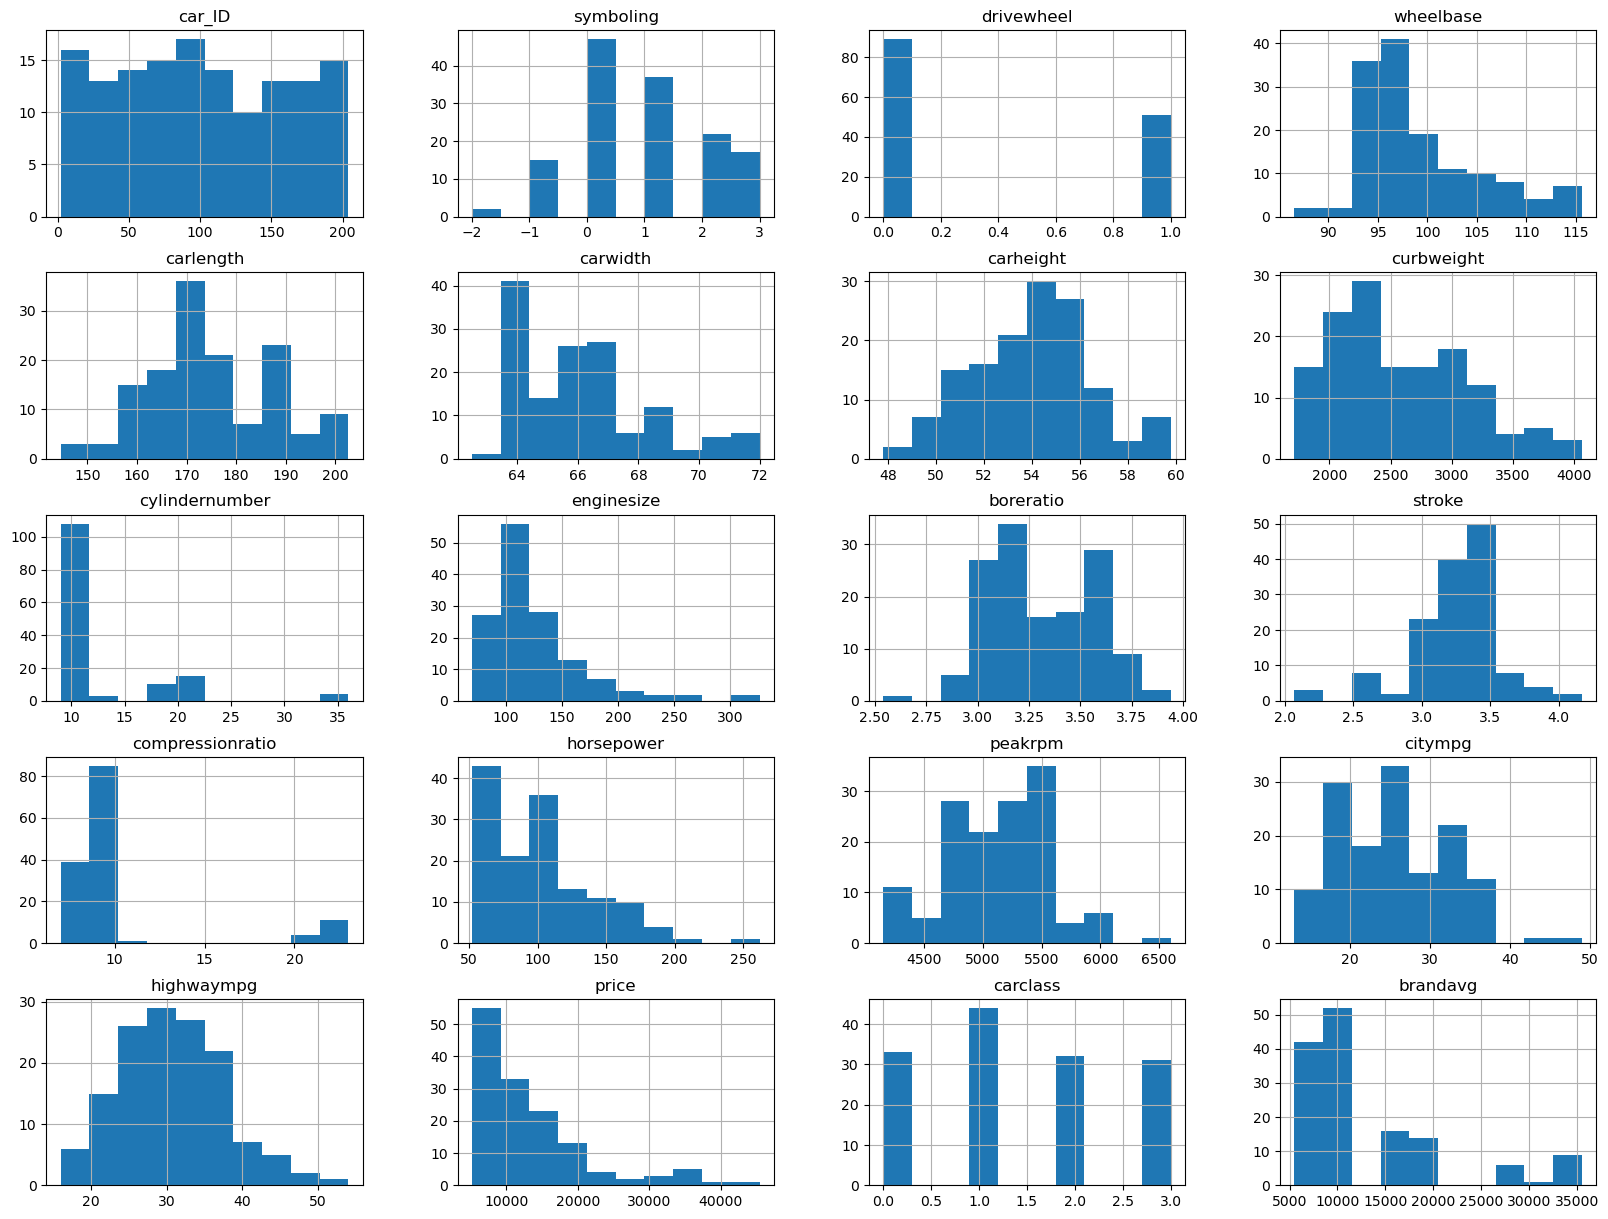

In [216]:
train_data.to_pandas().hist(bins=10,figsize=(20,15))
plt.show()

Most continuous features are roughly Normal, some are Right skewed including the dependent variable "Price"

Bivariate Analysis

<Axes: >

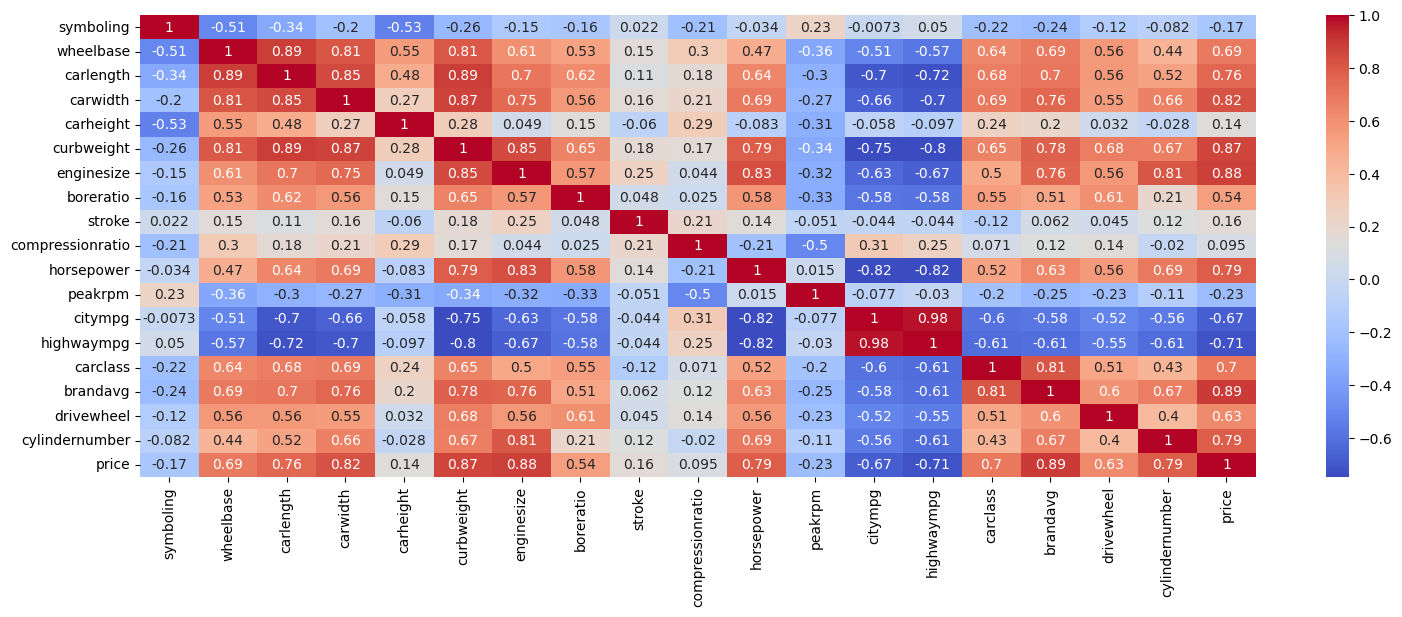

In [217]:
plt.figure(figsize=(18,6))
sns.heatmap(train_data[num_cols+["price"]].to_pandas().corr(),annot=True,cmap="coolwarm",robust=True)

Lot of Multi collinear features exists

Will deal with these multi collinear features based on modeling results

In [218]:
train_data.write_csv("../Day2_naive_modeling/train_preprocessed.csv")
test_data.write_csv("../Day2_naive_modeling/test_preprocessed.csv")
train_data.write_csv("../Day3_featureEngineering/train_preprocessed.csv")
test_data.write_csv("../Day3_featureEngineering/test_preprocessed.csv")

#  Pipeline Building

In [219]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['symboling', 'drivewheel',
                                                   'wheelbase', 'carlength',
                                                   'carwidth', 'carheight',
                                                   'curbweight',
                                                   'cylindernumber',
                                                   'enginesize', 'boreratio',
                                                   'stroke', 'compressionratio',
                                                   'horsepower', 'peakrpm',
                                                   'citympg', 'highwaympg',
                                                   'carclass', 'brandavg'])])),
                ('lr', LinearRegression())])

# Raw modeling

Rough estimation of our linear regression model

Mean Train Score: 0.941192415029938
Standard Deviation of Train Scores: 0.004738849232860281
Mean Test Score: 0.8516917066763163
Standard Deviation of Test Scores: 0.09805100235412202
Mean absolute Error: 2704.435014596838
R-squared on holdout set: 0.6129473518228576
Adjusted R-squared on holdout set: 0.3888642397203016


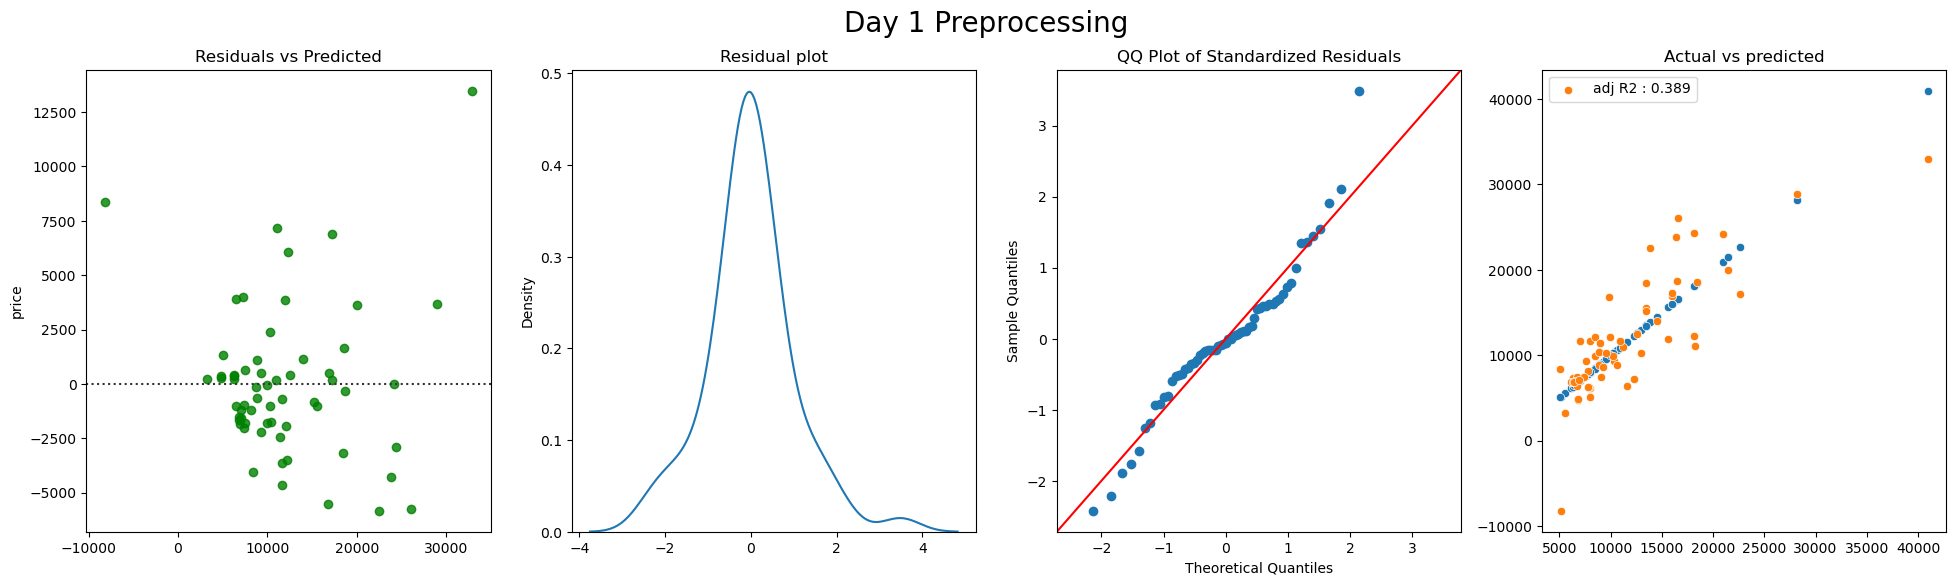

In [220]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2',return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.suptitle("Day 1 Preprocessing",fontsize=20)
plt.show()

# Results

## Model Performance Summary (Day 1)

### Cross-Validation Results

* **Mean Train Score**: 0.9412
* **Standard Deviation of Train Scores**: 0.0047
* **Mean Test Score**: 0.8517
* **Standard Deviation of Test Scores**: 0.0981

### Holdout Set Performance

* **Mean Absolute Error (MAE)**: 2704.435
* **R-squared (R²)**: 0.6129
* **Adjusted R-squared**: 0.3889

### Insights

* **Consistency**: The cross-validation results show moderate consistency with an average R² of 0.8517 and a standard deviation of 0.0981, indicating some variability in model performance across folds.
* **Overfitting**: The gap between the mean train score (0.9412) and test score (0.8517) suggests potential overfitting. The model performs better on familiar data compared to unseen data. Regularization techniques can be explored to address this.
* **Error Magnitude**: The MAE of 2704.435 on the holdout set indicates that the model's predictions deviate from the actual values by an average of approximately 2704 units, highlighting the prediction error magnitude.
* **Holdout Set R²**: An R² of 0.6129 on the holdout set shows the model explains about 61.29% of the variance in the holdout data, which signifies a good fit for a raw model.
* **Adjusted R²**: The adjusted R² of 0.3889 on the holdout set indicates that when considering the number of predictors, the model explains around 38.89% of the variance, suggesting a moderate explanatory power while accounting for model complexity.

# Conclusion
- over fitting to train data and performing poor on test set (Holdout set)